In [70]:
#numpy
import numpy as np
from numpy.random import multivariate_normal #For later example

#advectionGP

from advectionGP.models import AdjointAdvectionDiffusionModel as PDEModel

from advectionGP.wind import WindSimple#Wind model


from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.test import TestKernels #Unit test model


#Plotting tools
import matplotlib.pyplot as plt
import numpy.random as rd
rd.seed(123)

In [71]:
# generate sensor locations for training data with shape [total observations, 4], where each row has elements 
#[lower time location, upper time location, x location, y location]

tlocL = np.linspace(1,9,5) # lower time
xloc=np.linspace(1,9,4) # x locations
yloc=np.linspace(1,9,4) # y locations
sensN = len(xloc)*len(yloc) # total number of sensors 
obsN = len(tlocL) # total time points at which an observation is taken
X= np.zeros((obsN*sensN,4)) # obsN*sensN is total observations over all sensors and all times
# Build sensor locations
X[:,0] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[0] #lower time
X[:,2] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[1] # x location
X[:,3] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[2] # ylocation
X[:,1] = X[:,0]+0.1 # upper time

sensors = FixedSensorModel(X,0.1) # establish sensor model arguments are sensor locations and spatial averaging

In [72]:
k_0 = 0.01 #Diffusion
R=0.1
noiseSD = 0.05 #Observation noise
N_feat=2000 # number of features used to approximate ground truth GP
boundary = ([0,0,0],[10,10,10])# corners of the grid - in units of space
k = EQ(2, 2.0) # generate EQ kernel arguments are lengthscale and variance
res = [50,50,50] # grid size for time, x and y


u1 = 0.04
u2 = 0.04
windmodel=WindSimple(u1,u2) # establish fixed wind model

m = PDEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0) #initiate PDE model to build concentration

dt,dx,dy,dx2,dy2,Nt,Nx,Ny = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute source

sourceGT=(m.computeSourceFromPhi(z))# Compute source

In [73]:
concTrain=m.computeConcentration(sourceGT) # Compute concentration - runs advection diffusion forward model
yTrain= m.computeObservations(addNoise=True) # Compute observations with noise uses m.sensormodel for observation locations

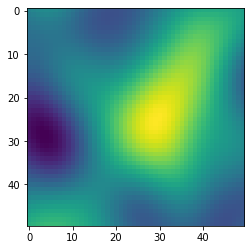

In [76]:
plt.imshow(sourceGT[9])

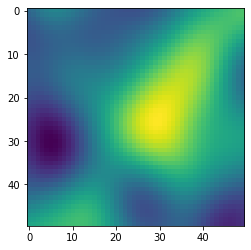

In [78]:
plt.imshow(concTrain[9])

In [79]:
X.shape

(80, 4)

In [80]:
yTrain.shape

(80,)

In [81]:
FullObs = np.hstack((X,yTrain[:,None]))

In [82]:
FullObs

array([[  1.        ,   1.1       ,   1.        ,   1.        ,
         -0.63392359],
       [  1.        ,   1.1       ,   1.        ,   3.66666667,
         -0.66183892],
       [  1.        ,   1.1       ,   1.        ,   6.33333333,
         -0.08342062],
       [  1.        ,   1.1       ,   1.        ,   9.        ,
          1.21737623],
       [  3.        ,   3.1       ,   1.        ,   1.        ,
         -1.56960399],
       [  3.        ,   3.1       ,   1.        ,   3.66666667,
         -3.70723848],
       [  3.        ,   3.1       ,   1.        ,   6.33333333,
          0.15371943],
       [  3.        ,   3.1       ,   1.        ,   9.        ,
          3.53776995],
       [  5.        ,   5.1       ,   1.        ,   1.        ,
         -3.1254368 ],
       [  5.        ,   5.1       ,   1.        ,   3.66666667,
         -7.96598733],
       [  5.        ,   5.1       ,   1.        ,   6.33333333,
         -0.56483642],
       [  5.        ,   5.1       ,   1.   

In [83]:
N_feat =2000 #Number of features used to infer the source
k1 = EQ(2, 2.0) 
k2 = EQ(2, 2.0) 

mPDE = PDEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k1,sensormodel=sensors,windmodel=windmodel,k_0=k_0) #Initiate new model for inference
regressPDE = mPDE.computeModelRegressors() # Compute regressor matrix
meanZPDE, covZPDE = mPDE.computeZDistribution(yTrain) # Infers z vector mean and covariance
sourceInfer = mPDE.computeSourceFromPhi(meanZPDE) # Generates estimated source using inferred distributio
concInfer = mPDE.computeConcentration(sourceInfer)
yOut = mPDE.computeObservations()

Calculating Adjoints...
79/80 
Calculating Phis...
1999/2000 


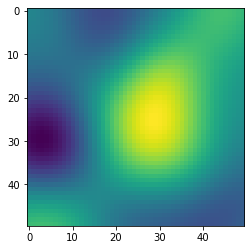

In [84]:
plt.imshow(sourceInfer[9])

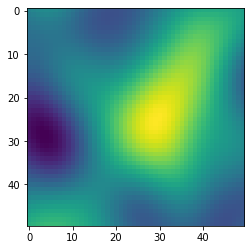

In [85]:
plt.imshow(sourceGT[9])

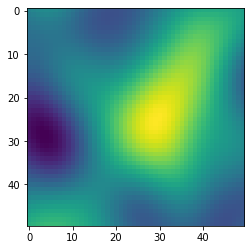

In [89]:
plt.imshow(sourceFromCSV[9])

In [54]:
np.mean((sourceGT-sourceInfer)**2)

0.2696490765459571

In [86]:
import csv
np.savetxt("Observations16Sens5Times.csv", FullObs, delimiter=",")
np.savetxt("GroundTruthSource16Sens5Times.csv", np.reshape(sourceGT,(res[0],res[1]*res[2])), delimiter=",")
np.savetxt("GroundTruthConc16Sens5Times.csv", np.reshape(concTrain,(res[0],res[1]*res[2])), delimiter=",")

In [88]:
sourceFromCSV=np.genfromtxt("GroundTruthSource16Sens5Times.csv",delimiter=',')
sourceFromCSV=np.reshape(sourceFromCSV,(50,50,50))